In [17]:
import glob
import os
import re
from datetime import datetime

import h5py
import numpy as np
from PIL import Image
from tqdm import tqdm

from scipy.stats import entropy
from skimage.filters import sobel
import cv2
import numpy as np
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

import matplotlib.pyplot as plt

In [18]:
def mirror_quality_features(gray):
    """Cechy niezależne od treści odbicia"""
    gray_norm = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # 1. Ostrość krawędzi - defekty są ostre, odbicia rozmyte
    laplacian_var = cv2.Laplacian(gray_norm, cv2.CV_64F).var()
    
    # 2. Wysokie częstotliwości - defekty, nie odbicia
    f = np.fft.fft2(gray_norm)
    fshift = np.fft.fftshift(f)
    h, w = gray.shape
    cy, cx = h // 2, w // 2
    mask = np.zeros((h, w), bool)
    mask[cy-h//6:cy+h//6, cx-w//6:cx+w//6] = True  # niskie freq
    high_freq_ratio = np.sum(np.abs(fshift)[~mask]) / (np.sum(np.abs(fshift)) + 1e-6)
    
    # 3. Lokalna szorstkość (mean filter residual)
    blurred = cv2.blur(gray_norm.astype(float), (5, 5))
    roughness = np.std(gray_norm - blurred)
    
    # 4. Liczba lokalnych "pików" - potencjalne defekty punktowe
    local_max = cv2.dilate(gray_norm, np.ones((3,3), np.uint8))
    peaks = np.sum(gray_norm == local_max) / gray_norm.size
    
    return np.array([
        laplacian_var,     # ostrość
        high_freq_ratio,   # drobne detale
        roughness,         # szorstkość
        peaks              # punktowe anomalie
    ])

In [5]:
def get_dataset_info(h5_path):
    """Wyświetla informacje o datasecie."""
    with h5py.File(h5_path, 'r') as f:
        print(f"Dataset: {h5_path}")
        print(f"Utworzono: {f.attrs.get('created', 'N/A')}")
        print(f"Liczba luster: {f.attrs.get('num_mirrors', 'N/A')}")
        print("-" * 40)

        total_obs = 0
        for mirror_id in range(200):
            grp_path = f'mirrors/{mirror_id:03d}'
            if grp_path in f and 'images' in f[grp_path]:
                n = f[grp_path].attrs.get('num_observations', 0)
                total_obs += n

        print(f"Łączna liczba obserwacji: {total_obs}")

# Get all images of mirror selected by grid_id
def get_mirror_gray(h5_path, grid_id):
    with h5py.File(h5_path, "r") as file:
        print(file.keys())
        img_rgb_grid_id = np.array(file[f"mirrors/{grid_id}/images"])
        gray_images = np.dot(img_rgb_grid_id[..., :3], [0.299, 0.587, 0.114])
    return gray_images

In [20]:
BASE_DIR = "/home/pgliwny/Praca/Computer_vision_for_MAGIC/"
h5_output = os.path.join(BASE_DIR, "data/data/2025/mirrors_dataset_test2.h5")
img_gray_012 = get_mirror_gray(h5_output, "012")
print(img_gray_012.shape)        

<KeysViewHDF5 ['mirrors']>
(27, 83, 101)


In [48]:
with h5py.File(h5_output, "r") as file:
    print(file["mirrors/022"].keys())
    print(file["mirrors/022/source_files"][12])

<KeysViewHDF5 ['images', 'source_files']>
b'IRCamM1T20251130_164000M.jpg'


In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(12, 7))
ax[0].plot(quality_features_array[:, 0])
ax[1].plot(quality_features_array[:, 1])
ax[2].plot(quality_features_array[:, 2])
ax[3].plot(quality_features_array[:, 3])

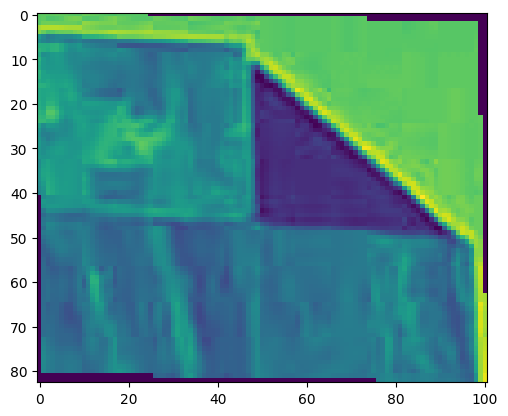

In [37]:
plt.imshow(img_gray_012[8, :, :])

In [34]:
img_gray_022 = get_mirror_gray(h5_output, "022")
print(img_gray_022.shape)        

<KeysViewHDF5 ['mirrors']>
(27, 86, 97)


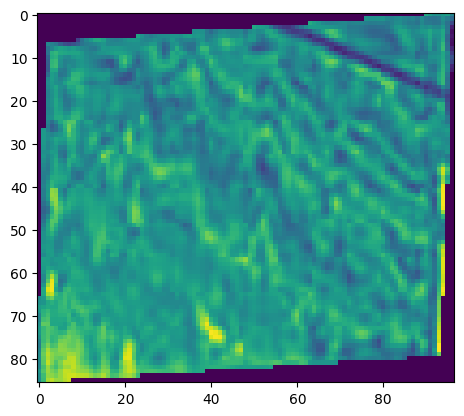

In [41]:
plt.imshow(img_gray_022[6, :, :])

In [38]:
quality_features_array = np.zeros((27, 4))
for i in range(0, 27):
    quality_features_array[i, :] = mirror_quality_features(img_gray_022[i, :, :])

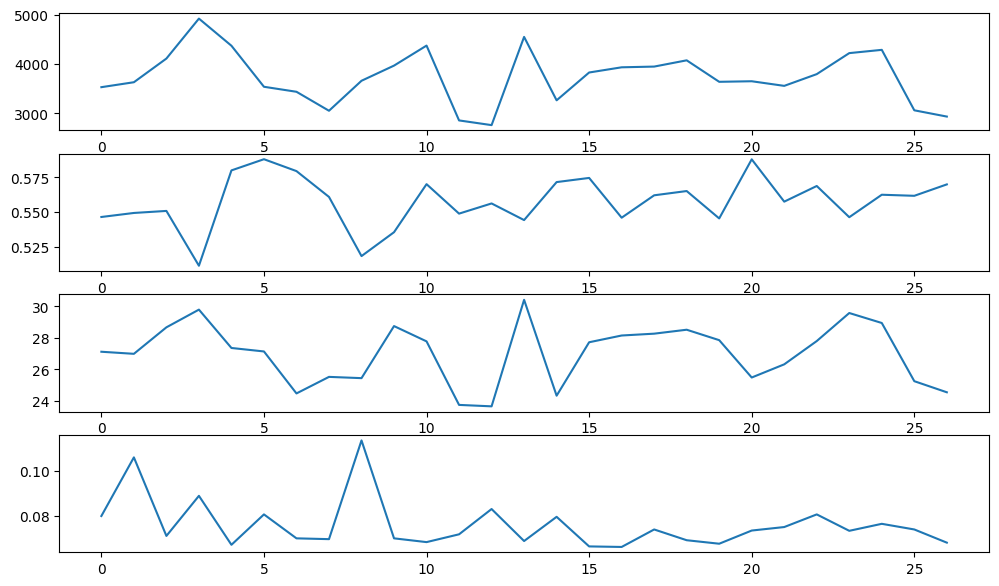

In [33]:
fig, ax = plt.subplots(4, 1, figsize=(12, 7))
ax[0].plot(quality_features_array[:, 0])
ax[1].plot(quality_features_array[:, 1])
ax[2].plot(quality_features_array[:, 2])
ax[3].plot(quality_features_array[:, 3])

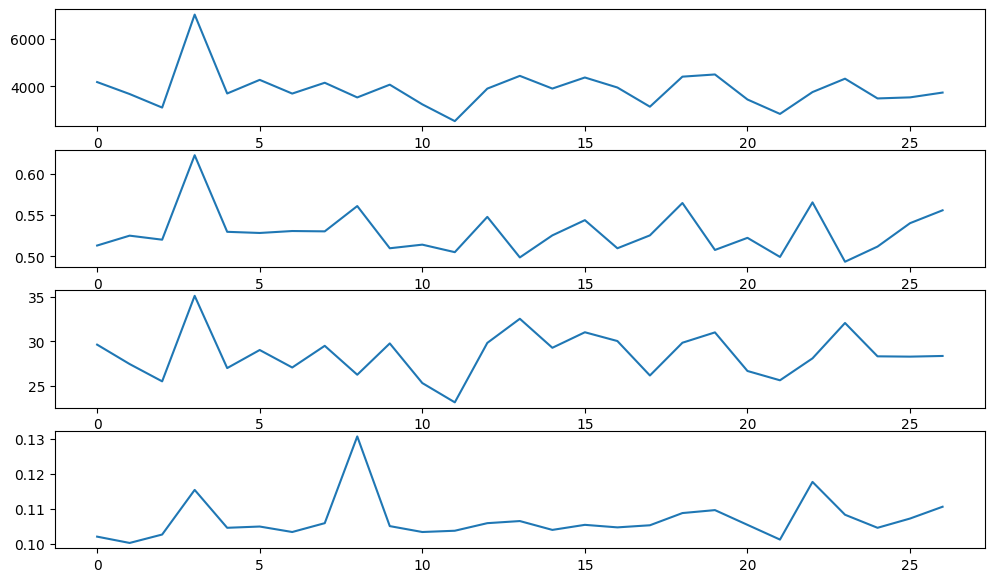

In [39]:
fig, ax = plt.subplots(4, 1, figsize=(12, 7))
ax[0].plot(quality_features_array[:, 0])
ax[1].plot(quality_features_array[:, 1])
ax[2].plot(quality_features_array[:, 2])
ax[3].plot(quality_features_array[:, 3])